## So, you've done a ton of expanded-ensemble calculations and you want to calculate the free energy $\Delta G (\lambda=0 \rightarrow \lambda=1)$...

Hopefully, you've successfully scraped the data into a directory for analysis, like so:
```
$ python scrape_data.py test-projectdata test-scraped-data 0
```

In [3]:
import os
os.system('python scrape_data.py test-projectdata test-scraped-data 0')

0

.../which creates files like this:

In [4]:
%ls -1 test-scraped-data

r0-c0.distances.npy
r0-c0.energies.npy
r0-c0.states.npy


If this data comes from Wang-Landau expanded-ensemble sampling, the $\lambda$-value moves around according to Metropolis-Gibbs sampling.

Let's look at the state trajetcory for this first clone...

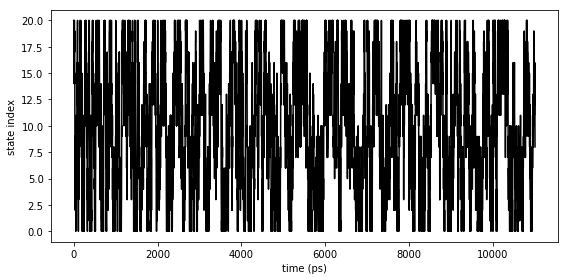

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

states = np.load('test-scraped-data/r0-c0.states.npy')
time_in_ps = np.arange(len(states))

plt.figure(figsize=(8,4))
plt.plot(time_in_ps, states, 'k-')
plt.xlabel('time (ps)')
plt.ylabel('state index')
plt.tight_layout()
plt.show()

Stored in the `r0-c0.energies.npy` file are the $\Delta U_{kl}$ values.  For a conformation sampled in ensemble $k$, this is the energy difference $\Delta U = U^{(\lambda = l)} - U^{(\lambda = k)}$.

Let's slice out samples from each ensemble, and look at the distribution of energies $P(\Delta U)$

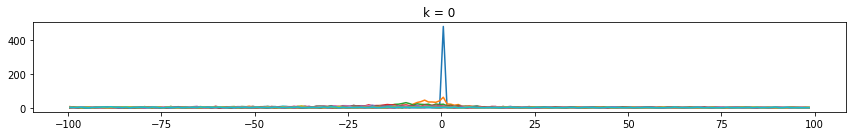

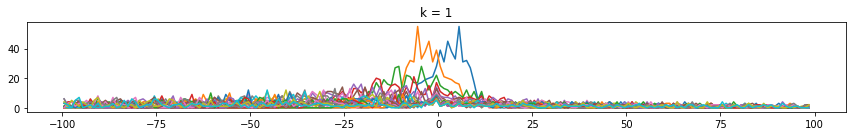

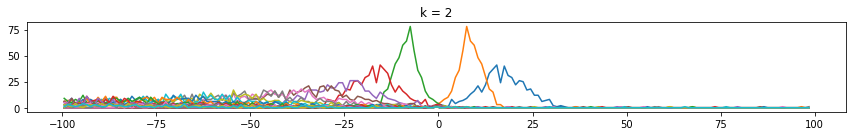

In [11]:
lambda_values = np.arange(0.0, 1.05, 0.05)
K = len(lambda_values)

energies = np.load('test-scraped-data/r0-c0.energies.npy')

for k in [0,1,2]: # range(K):

    plt.figure(figsize=(12,2))
    plt.title('k = %d'%k)
    for l in range(K):
        if k != l:
            k_energies = energies[(states == k),:]
            # print('k,l =', k,l, 'k_energies.shape', k_energies.shape)
            hist, bin_edges = np.histogram(k_energies[:,l], bins=np.arange(-100., 100., 1.)) ###, normed=True)
            bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
            # print('hist, bin_edges', hist, bin_edges)
            plt.plot(bin_centers, hist, label='$l$ = %d'%l)
    #plt.legend()
    plt.tight_layout()
    plt.show()
    


In [12]:
import os, sys
import numpy as np

#from math import *
import pymbar # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

# help(pymbar)

states.shape (11004,)
energies.shape (11004, 21)
distances.shape (11004,)
beta 0.4008153224964093
np.argsort(states) [8108 7754  500 ... 8554 8550    0]
u_kn [[-4.72088900e+00  4.26230980e-01  7.26955700e+00 ...  9.37363730e+02
   7.93711570e+02  7.81071480e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.90495540e+02
   7.54025990e+02  7.42017910e+02]
 [ 4.72088900e+00 -4.26230980e-01 -7.26955700e+00 ...  8.43627360e+02
   7.14340410e+02  7.02964330e+02]
 ...
 [ 8.49760000e+01 -7.67215740e+00 -1.30852020e+02 ...  4.68681980e+01
   3.96855880e+01  3.90535830e+01]
 [ 8.96968900e+01 -8.09838850e+00 -1.38121580e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.95085858e+01 -1.00569852e+01 -1.38182752e+02 ... -8.91785940e-03
  -3.24173203e-02 -6.75657322e-03]]
N_k [523 524 526 528 524 527 528 528 527 525 525 527 528 529 527 523 521 515
 516 516 517   0]
Running MBAR...
K (total states) = 22, total samples = 11004
N_k = 
[523 524 526 528 524 527 528 528 527 525 52

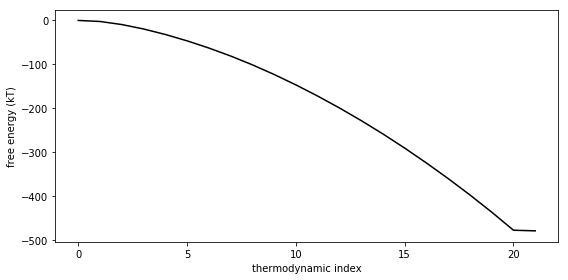

In [13]:
# read in the ee + umbrella sampling data
states = np.load('test-scraped-data/r0-c0.states.npy')
energies = np.load('test-scraped-data/r0-c0.energies.npy')
distances = np.load('test-scraped-data/r0-c0.distances.npy')

print('states.shape', states.shape)
print('energies.shape', energies.shape)
print('distances.shape', distances.shape)


def estimate_free_energy(states, energies, distances):
    """Use MBAR to estimate the free energy vs. lambda"""

    ###########################
    # Main

    # Physical constants (in kJ)
    kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K

    lambda_values = np.arange(0.0, 1.05, 0.05)

    # In addition to the 21 lambda values, there is one more thermo ensemble -- the *unbiased* ensemble
    # with no harmonic restraint
    K = len(lambda_values) + 1
    unbiased_state_index = K - 1

    r0 = 0.4  # equilibrium umbrella distance in nm
    kvalue = 200.0    # kJ/nm^2 umbrella force constant

    # MBAR parameters

    # Parameters
    temperature = 300.

    # maximum number of snapshots/simulation:
    N_max = energies.shape[0] 
    ### TO DO in the future collect *all* run and clone energies and flatten

    T_k = np.ones(K,float)*temperature # inital temperatures are all equal 
    beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))
    print('beta',  beta)

    # Allocate storage for simulation data
    N_k = np.zeros([K], np.int32) # N_k[k] is the number of snapshots from umbrella simulation k
    # rvalues[k] is the spring center location (in nm) for umbrella simulation k
    x_kn = np.zeros([K,N_max], np.float64) # x_kn[k,n] is the Val122_CA-TRP_CA distance (in nm) for snapshot n from umbrella simulation k
    u_kn = np.zeros([K,N_max], np.float64) # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
    g_k = np.zeros([K],np.float32);

    
    ### To do MBAR, we need to convert to data to u_kn format
    print('np.argsort(states)', np.argsort(states))

    Ind = np.argsort(states)
    energies_sorted = energies[Ind,:]
    states_sorted = states[Ind]
    distances_sorted = distances[Ind]
    for k in range(K-1):

        # Count how many snapshots belong to each k
        N_k[k] = np.where(states_sorted == k, 1, 0).sum()

        # fill the energies
        u_kn[k, :] = energies_sorted[:, k]

    # for the last (unbiased) ensemble (with no samples), subtract the harmonic potential
    u_kn[K-1, :] = u_kn[K-2, :] - beta * (kvalue/2.0) * (distances_sorted - r0)**2
    print('u_kn', u_kn)
    print('N_k', N_k)

    # Initialize MBAR.
    print('Running MBAR...')
    mbar = pymbar.MBAR(u_kn, N_k, verbose = True) # method = 'adaptive')

    # Set zero of u_kn -- this is arbitrary.
    u_kn -= u_kn.min()

    Deltaf_ij, dDeltaf_ij, Theta_ij = mbar.getFreeEnergyDifferences()
    # print('Deltaf_ij, dDeltaf_ij, Theta_ij', Deltaf_ij, dDeltaf_ij, Theta_ij)

    print('Deltaf_ij[0,K-1]', Deltaf_ij[0,K-1])
    print('dDeltaf_ij[0,K-1]', dDeltaf_ij[0,K-1])

    df, sigma_df = np.zeros(K), np.zeros(K)
    for i in range(K-1):
        # print('Deltaf_%d,%d = '%(i,i+1), Deltaf_ij[i,i+1], '+/-', dDeltaf_ij[i,i+1])
        df[i+1] = df[i] + Deltaf_ij[i,i+1]
        sigma_df[i+1] = sigma_df[i] + dDeltaf_ij[i,i+1]

    return df, sigma_df


##### Estimate $\Delta G$
df, sigma_df = estimate_free_energy(states, energies, distances)


##### plot the results
from matplotlib import pyplot as plt
%matplotlib inline

lambda_values = np.arange(0.0, 1.05, 0.05)
# In addition to the 21 lambda values, there is one more thermo ensemble -- the *unbiased* ensemble
# with no harmonic restraint
K = len(lambda_values) + 1


plt.figure(figsize=(8,4))
plt.plot(np.arange(K), df, 'k-')
plt.fill_between(np.arange(K), df+sigma_df, df-sigma_df, alpha=0.5)
plt.xlabel('thermodynamic index')
plt.ylabel('free energy (kT)')
plt.tight_layout()
plt.show()

beta 0.4008153224964093
np.argsort(states) [31 59 20 40 50 24 33 57  6 43 21 18 17  2  9 30 54 56 46 35  8  7 25 47
 23  4  3 51 19 45 48 12 53  1 42 41 60 16  5 55 32 15 44 52 37 39 14 34
 38 27 26 22 36 49 29 13 10 11 58  0 28]
u_kn [[ 6.68221650e+00  7.07755770e-01  7.58414740e-01 ...  8.75265420e+02
   7.09019930e+02  8.28649000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.29198820e+02
   6.71703090e+02  7.87216550e+02]
 [-6.68221650e+00 -7.07755770e-01 -7.58414740e-01 ...  7.83132220e+02
   6.34386260e+02  7.45784100e+02]
 ...
 [-1.20279890e+02 -1.27396030e+01 -1.36514650e+01 ...  0.00000000e+00
   0.00000000e+00  4.14324600e+01]
 [-1.26962110e+02 -1.34473590e+01 -1.44098800e+01 ... -4.60666130e+01
  -3.73168480e+01  0.00000000e+00]
 [-1.27086490e+02 -1.34528123e+01 -1.57032378e+01 ... -4.61053702e+01
  -3.73267894e+01 -3.49109176e-04]]
N_k [5 1 6 3 3 1 2 3 3 1 3 3 5 4 0 3 3 6 2 3 1 0]
Running MBAR...
K (total states) = 22, total samples = 61
N_k = 
[5 1 6 3 3 1 2

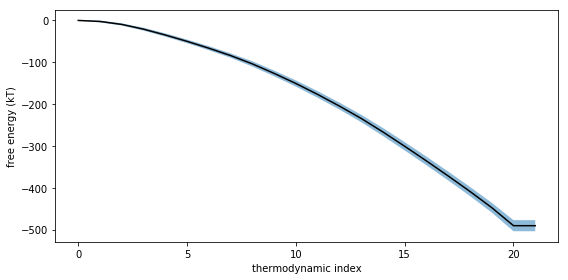

In [15]:
# what happens with less data?
skip = 5000
stride = 100

# estimate free energy
df, sigma_df = estimate_free_energy(states[skip::stride], energies[skip::stride,:], distances[skip::stride])

plt.figure(figsize=(8,4))
plt.plot(np.arange(K), df, 'k-')
plt.fill_between(np.arange(K), df+sigma_df, df-sigma_df, alpha=0.5)
plt.xlabel('thermodynamic index')
plt.ylabel('free energy (kT)')
plt.tight_layout()
plt.show()

